In [99]:
import autograd.numpy as np 
from autograd import grad, elementwise_grad, jacobian, make_jvp 
from autograd.scipy.special import erf

import GPy
from GPy.kern import Kern
from GPy.core.parameterization.param import Param

import matplotlib.pyplot as plt
from scipy.linalg import pinvh

## Vectorised Kernel And Gradients

In [100]:
def hq(tmat1, tmat2, lq, bvec, svec, d1s, d2s, debug=False):
    """
    hq function for ode1 one kernel for the qth force. d is the number of outputs 
    
    :param tmat1[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param tmat2[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param lq[ndarray 1x]: single scalar contained in ndarray. Lengthcale for qth force 
    :param bvec[ndarray dx1]: ndarray of B parameters (frequencies^2)
    :param svec[ndarray dx1]: ndarray of sensitivities for the qth force 
    :param d1[ndarray d<x1]: specific outputs to be evaluated for tmat1
    :param d2[ndarray d<x1]: specific outputs to be evaluated for tmat2
                                
    """
    n1 = tmat1[list(tmat1.keys())[0]].shape[0]
    n2 = tmat2[list(tmat2.keys())[0]].shape[0]
    
    d1_ = len(d1s)
    d2_ = len(d2s)
    
    out = None
    
    for d1 in d1s:
        bd1 = bvec[d1]
        vd1 = bd1 * lq * 0.5
        td1 = tmat1[d1]
        sd1 = svec[d1]
        
        fac = np.exp(vd1**2 - bd1 * td1[...,None]) 
        
        erf_minus = erf( td1[..., None] / lq - vd1 ) +  erf( vd1 )
        for d2 in d2s:
            bd2 = bvec[d2]
            td2 = tmat2[d2]
            sd2 = svec[d2]
            
            fac_ = fac / (bd1 + bd2)
            
            delta = (td1[...,None] - td2)
            erf_plus = erf(  delta / lq - vd1 ) +  erf( td2[None, ...] / lq + vd1 )
            
            
            erf_minus_ = np.dot(np.exp(-bd2 * td2[..., None]), erf_minus.reshape(1, -1) ).T
            
            all_terms = fac_.reshape(-1,1) * (np.exp(bd1 * td2[None, ...]) * erf_plus - erf_minus_)
            
            
            if out is None:
                out = (sd1 * sd2 * all_terms)[None, ...]
            else:
                out = np.concatenate((out, (sd1 * sd2 * all_terms)[None,...] ), axis=0)
    out = out.reshape(d1_,d2_,n1, n2)
    return np.transpose(out, (0,2,1,3)).reshape(n1 *d1_ , n2 * d2_)



def k_f(tmat1, tmat2, lvec, bvec, Smat, d1s=None, d2s=None, debug=False,hq=hq):
     """
    kernel function for ode1 one kernel K_ff
    
    :param tmat1[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param tmat2[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param lvec[ndarray qx1]: single scalar contained in ndarray. Lengthcale for qth force 
    :param bvec[ndarray dx1]: ndarray of B parameters (frequencies^2)
    :param svec[ndarray qxd]: ndarray(matrix) of sensitivities
    :param d1[ndarray d<x1]: specific outputs to be evaluated for tmat1
    :param d2[ndarray d<x1]: specific outputs to be evaluated for tmat2
                                
    """
    q = lvec.shape[0]
    d = bvec.shape[0]
    
    n1 = tmat1[list(tmat1.keys())[0]].shape[0]
    n2 = tmat2[list(tmat2.keys())[0]].shape[0]
     
    
    if d1s is None:
        d1s = range(bvec.shape[0])
    if d2s is None:
        d2s = range(bvec.shape[0])
        
    d1_ = len(d1s)
    d2_ = len(d2s)
    kf = np.zeros((n1 * d1_, n2 * d2_))
    
    for i_q in range(q):

        h_q1 = hq(tmat1, tmat2, lvec[i_q], bvec, Smat[i_q], d1s=d1s, d2s=d2s, debug=False)
        h_q2 = hq(tmat2, tmat1, lvec[i_q], bvec, Smat[i_q], d1s=d2s, d2s=d1s, debug=False)
        
        if debug:
        
            htest = hq_old(tmat1, tmat2, lvec[i_q], bvec, Smat[i_q], d1s=d1s, d2s=d2s)
            print((htest ==h_q1).all())
            htest = hq_old(tmat2, tmat1, lvec[i_q], bvec, Smat[i_q], d1s=d2s, d2s=d1s)
            print((htest ==h_q2).all())
            plt.imshow(h_q1 + h_q2.T  )
            plt.show()
                       
        kf += 0.5 * lvec[i_q] * np.sqrt(np.pi) * ( h_q1 + h_q2.T  )
        
    return kf


def grad_kf(tmat1, tmat2, lvec, bvec, Smat):
    """
    gradient of kernel function for ode1 one kernel grad_theta(K_ff)
    
    :param tmat1[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param tmat2[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param lvec[ndarray qx1]: single scalar contained in ndarray. Lengthcale for qth force 
    :param bvec[ndarray dx1]: ndarray of B parameters (frequencies^2)
    :param svec[ndarray qxd]: ndarray(matrix) of sensitivities
                                
    """
    gradient_funcs = [jacobian(k_f, pi) for pi in (2,3,4)]
    gradients = [gradient(tmat1,tmat2, lvec, bvec, Smat) for gradient in gradient_funcs]
    return gradients

In [101]:
def diag_hq(tmat, lq, bvec, svec, d1s):
    """
    duag hq function for ode1 one kernel for the qth force.
    d is the number of outputs 
    
    :param tmat1[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param tmat2[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param lq[ndarray 1x]: single scalar contained in ndarray. 
                                  Lengthcale for qth force 
    :param bvec[ndarray dx1]: ndarray of B parameters (frequencies^2)
    :param svec[ndarray dx1]: ndarray of sensitivities for the qth force 
    :param d1s[ndarray d<x1]: specific outputs to be evaluated for tmat1
                                
    """
    
    d = len(d1s)
    
    n = tmat[list(tmat.keys())[0]].shape[0]
    
    out = None
    
    for d1 in d1s:
        bd = bvec[d1]
        vd =  bd * lq * 0.5
        td = tmat[d1]
        sd = svec[d1]
        
        fac = np.exp(vd**2 - bd * td) / 2 * bd
        
        erf_minus = erf( td / lq - vd ) +  erf( vd )

        delta = np.zeros(n)
        erf_plus = erf(  delta / lq - vd ) +  erf( td / lq + vd )


        erf_minus_ = np.exp(-bd * td) * erf_minus

        all_terms = fac * (np.exp(bd * td) * erf_plus - erf_minus_)

        if out is None:
            out = (sd * sd * all_terms)[..., None]
        else:
            out = np.concatenate((out, 
                                  (sd * sd * all_terms)[..., None] ),
                                 axis=0)
    return out.reshape(n * d , 1)


def diag_k_f(tmat, lvec, bvec, Smat, d1s=None, debug=False):
     """
    diag kernel function for ode1 one kernel diag(K_ff)
    
    :param tmat1[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param tmat2[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param lvec[ndarray qx1]: single scalar contained in ndarray. 
                              Lengthcale for qth force 
    :param bvec[ndarray dx1]: ndarray of B parameters (frequencies^2)
    :param svec[ndarray qxd]: ndarray(matrix) of sensitivities
    :param d1[ndarray d<x1]: specific outputs to be evaluated for tmat1
    :param d2[ndarray d<x1]: specific outputs to be evaluated for tmat2
                                
    """
    q = lvec.shape[0]
    n = tmat[list(tmat.keys())[0]].shape[0]
    
    if d1s is None:
        d1s = range(bvec.shape[0])
    
    d = len(d1s)
        
    kf = np.zeros(n * d)
    for i_q in range(q):
        h_q = diag_hq(tmat, lvec[i_q], bvec, Smat[i_q], d1s)
        
        kf += np.squeeze(lvec[i_q] * np.sqrt(np.pi) * h_q)
        
    return kf


def k_yd_fq(tmat1, tmat2, lq, bvec, Smat, ds=None, debug=False,hq=hq):
    """
    Latent force prediction kereel. Kernel between 
                               outputs and latent force
    
    :param tmat1[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param tmat2[dict[ndarrays]]: dictionary of ndarrays where each key
                                  correponds to an output
    :param lvec[ndarray qx1]: single scalar contained in ndarray. 
                              Lengthcale for qth force 
    :param bvec[ndarray dx1]: ndarray of B parameters (frequencies^2)
    :param svec[ndarray qxd]: ndarray(matrix) of sensitivities
    :param ds[ndarray d<x1]: specific outputs to be evaluated
                                
    """

    d = bvec.shape[0]
    n1 = tmat1[list(tmat1.keys())[0]].shape[0]
    n2 = tmat2[list(tmat2.keys())[0]].shape[0]
    
    if ds is None:
        ds = range(d)

    d = len(ds)
    out = np.zeros((d * n1, n2))

    for d1 in ds:
        bd1 = bvec[d1]
        vd1 = bd1 * lq * 0.5
        td1 = tmat1[d1]
        td2 = tmat2[d1]
        sd1 = Smat[d1]
        
        
        
        delta = (td1[...,None] - td2)
        
        fac = np.exp(vd1**2 - bd1 * delta) 
        
        erf_plus = erf(  delta / lq - vd1 ) +  erf( td2[None, ...] / lq + vd1 )
        out[d1 * tmat1.shape[0]: (d1 + 1) * tmat1.shape[0],:] = 0.5 * np.sqrt(np.pi) * lq * Smat[d1]  * fac * erf_plus
    return out



## Kernel Class

In [102]:
class LFM1(GPy.kern.Kern):
    """
    Kernel Object for ODE1 LFM model
    
    dy_d/dt + B_d y_d  = \sum S_qd f_d(t) 
    
    bvec = {B_d} (frequencies)
    lengthscales = {l_q} (lengthscales)
    Smat = {S_qd} (Sensitivities)
    """
    
    def __init__(self,input_dim, bvec=np.array([1.0]),
                 lengthscales=np.array([1.0]),
                 Smat=np.array([[1.0]]),
                 active_dims=(0,1)):
    
        super(LFM1, self).__init__(input_dim, active_dims, 'LFM1')
        
        self.bvec = Param('bvec', bvec)
        self.lengthscales = Param('lengthscales', lengthscales)
        self.Smat = Param('Smat', Smat)
        self.link_parameters(self.bvec, self.lengthscales, self.Smat)
        self.show = False
    
    @staticmethod
    def preprocess(X):
        """
        Preprocesses the 2dimensional input
        into dictionary of outputs required by
        helper functions (i.e. k_f , h_q)
        
        :params X[ndarray nx2]: first col is data
                    second col is the index of
                    the output
        
        :return [dict]: keys correpond to output
                        index
        """
        d1s = np.unique(X[:,1]).astype(int)
        X_ = {} 
        for d1 in d1s:
            X_[d1] =  X[X[:,1] == d1][:,0] 
        return d1s, X_
    
    def K(self,X,X2):
        """
        Kernel to be used with
        CoregionalisedRegression model
        
        :params X[ndarray nx2]: first col is data
                    second col is the index of
                    the output
                    
        :params X2[ndarray nx2]: first col is data
                    second col is the index of
                    the output
        """
        if X2 is None: X2 = X
        d1s, X_ = self.preprocess(X)
        d2s, X2_ = self.preprocess(X2)
            
        k =  k_f(X_, X2_, self.lengthscales, self.bvec,
                 self.Smat, d1s, d2s,  debug=False, hq=hq)
        return k 
    
    def K_y_f(self, X, X2, q):
        """
        Latent force inference kernel
        
        :params X[ndarray nx2]: first col is data
                    second col is the index of
                    the output
                    
        :params X2[ndarray nx2]: first col is data
                    second col is the index of
                    the output
        """
        d1s, X_ = self.preprocess(X)
        d2s, X2_ = self.preprocess(X2)
        
        k =  k_yd_fq(X_, X2_, self.lengthscales[q], self.bvec,
                     self.Smat[q], ds=d1s, debug=False, hq=hq)
        return k
    
    def K_ff(self, X, X2, q):
        """
        Prior RBF kernel
        
        :params X[ndarray nx2]: first col is data
                    second col is the index of
                    the output
                    
        :params X2[ndarray nx2]: first col is data
                    second col is the index of
                    the output
        """
        d1s, X_ = self.preprocess(X)
        d2s, X2_ = self.preprocess(X2)
        
        lq = self.lengthscales[q]
        return np.exp(-(X_[0][...,None] - X2_[0] )**2/ lq**2)
    
    def Kdiag(self, X):
        """
        :params X[ndarray nx2]: first col is data
                    second col is the index of
                    the output
        """
        d1s, X_ = self.preprocess(X)
        return diag_k_f(X_, self.lengthscales, self.bvec,
                        self.Smat, d1s=d1s, debug=False)
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        d1s, X_ = self.preprocess(X)
        d2s, X2_ = self.preprocess(X2)

        gradients = grad_kf(X_, X2_, self.lengthscales.values, 
                            self.bvec.values, self.Smat.values)

        db = gradients[1]
        dl = gradients[0]
        dS = gradients[2]

        self.bvec.gradient = np.sum(db * dL_dK[..., None],
                                    axis=(0,1))
        self.lengthscales.gradient = np.sum(dl * dL_dK[..., None],
                                            axis=(0,1))
        self.Smat.gradient = np.sum(dS * dL_dK[..., None, None],
                                    axis=(0,1))


## GPy Experiments

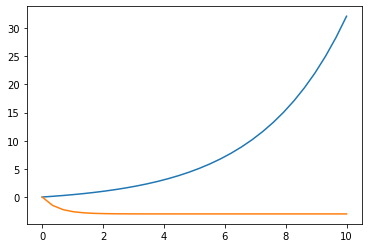

done init


TypeError: unsupported format string passed to NoneType.__format__

In [96]:
shift = 0
end = 30
noise = 1e-7
t1 = np.linspace(0,10, 30).reshape(-1,1)  + shift
# t1 = np.linspace(0,20, 30).reshape(-1,1)

bvec = np.array([1.0, 1.0])
lvec = np.array([1.0])
Smat = np.array([[1.0, 1.0]])

# create simple GP Model
kernel_lfm1 = LFM1(input_dim=2, bvec=bvec,
                 lengthscales=lvec,
                 Smat=Smat)


# y1 = np.exp(t1)  * (t1)
b = - 1
# y1 = np.exp(0.1 * t1) * (np.sin(t1) - np.cos(t1)) / (0.1**2 + 1)
y1 = np.exp( 0.35 * t1)  - 1
y2 = 3 * ( np.exp(- 2 * t1 ) - 1)

plt.plot(t1, y1)
plt.plot(t1, y2)
plt.show()

m = GPy.models.GPCoregionalizedRegression(X_list=[t1,t1], Y_list=[y1, y2], kernel=kernel_lfm1)

m.mixed_noise.Gaussian_noise_0.variance = noise
m.mixed_noise.Gaussian_noise_1.variance = noise

# m.mixed_noise.Gaussian_noise_0.variance.fix()
# m.mixed_noise.Gaussian_noise_1.variance.fix()
print("done init")

optimize = True
plot = True
if optimize:
    m.optimize('bfgs', max_iters=200, messages=True)
if plot:

    slices = GPy.util.multioutput.get_slices([t1,t1])
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    m.plot(fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0},ax=axs[0])
    m.plot(fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1}, ax=axs[1])
    plt.show()
    
    
#     tstar =  np.linspace(0 + shift,end + shift, 100).reshape(-1,1)


#     k_train =  m.kern.K(t1,t1)


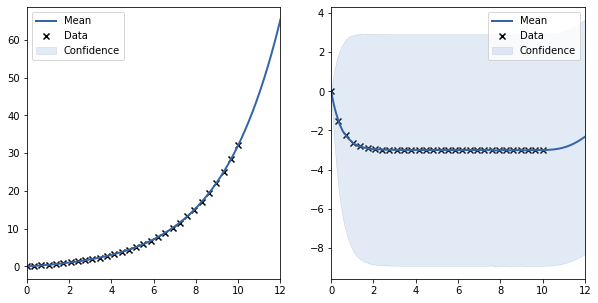

In [112]:
slices = GPy.util.multioutput.get_slices([t1,t1])
fig, axs = plt.subplots(1,2, figsize=(10,5))

m.plot(plot_limits=(shift, 12 + shift), fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0},ax=axs[0])
m.plot(plot_limits=(shift, 12 + shift), fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1}, ax=axs[1])
plt.show()
    

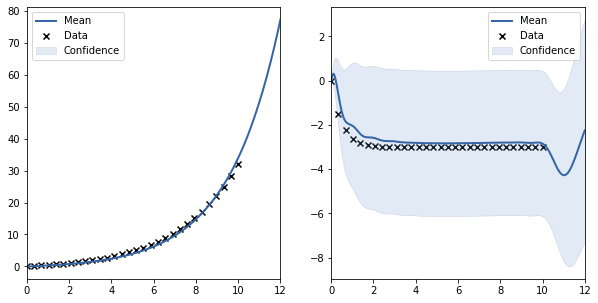

In [105]:
slices = GPy.util.multioutput.get_slices([t1,t1])
fig, axs = plt.subplots(1,2, figsize=(10,5))

m.plot(plot_limits=(shift, 12 + shift), fixed_inputs=[(1,0)],which_data_rows=slices[0],Y_metadata={'output_index':0},ax=axs[0])
m.plot(plot_limits=(shift, 12 + shift), fixed_inputs=[(1,1)],which_data_rows=slices[1],Y_metadata={'output_index':1}, ax=axs[1])
plt.show()

### Latent Force

In [82]:
from scipy.linalg import pinvh

def latent_force(model, X, q=0):
    """
    returns means and variances of infered qth latent force.
    For multioutput must preprocess input X with vec(X).
    
    :param model[GPy.model]: GPy model object 
    :param X[ndarray]: Set of query points for latent force
    :param q[int]: index of latent force.
    
    :returns (ndarray, ndarray): tuple containing mu, sigma
    """
    Xtrain = np.array(m.X)
    Ytrain = np.array(m.Y)
    Kyf  = model.kern.K_y_f(Xtrain, X, q)
    Kyy = model.kern.K(Xtrain)
    Kyy += np.sqrt(m.likelihood.variance) * np.eye(Kyy.shape[0])
    Kyyinv = pinvh(Kyy)
    
    Kff =  np.squeeze(m.kern.K_ff(X,X, q))
    W =  ((Kyf.T).dot(Kyyinv))
    
    cross_term = W.dot(Kyf)
    
    sigma = Kff - cross_term
    return (W).dot(Ytrain), np.sqrt(np.diag(sigma))

tstar =  np.linspace(0,30, 100).reshape(-1,1)
mu_pred , sigma_pred =  m.predict(tstar, full_cov=False)
sigma_pred = np.sqrt(sigma_pred).flatten()

mu_lfm, sigma_lfm = latent_force(m, tstar)
mu_lfm = mu_lfm.flatten()
sigma_lfm = sigma_lfm.flatten()

In [83]:


# plt.plot(tstar, mu_pred, label="$\mu$ prediction")
# plt.fill_between(tstar.flatten(), mu_pred.flatten()-2*sigma_pred, mu_pred.flatten()+2*sigma_pred, alpha=.2, label="$\sigma$ prediction")

plt.plot(tstar, mu_lfm, label="$\mu$ latent force")
plt.fill_between(tstar.flatten(), mu_lfm-2*sigma_lfm, mu_lfm+2*sigma_lfm, alpha=.2, label="$\sigma$ latent force")
plt.legend()